In [59]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import f1_score

%matplotlib inline

### Read in Raw Result

In [69]:
def process_row_data(input_path, output_path):
    results = pd.read_csv(input_path)
    results.columns = results.columns.str.strip()
    results['w_support'] = (results['ww'] + results['wm'])
    results['m_support'] = (results['mm'] + results['mw'])

    results['w_precision'] = results['ww'] / (results['ww'] + results['mw'])
    results['w_recall'] = results['ww'] / (results['ww'] + results['wm'])
    results['m_precision'] = results['mm'] / (results['mm'] + results['wm'])
    results['m_recall'] = results['mm'] / (results['mm'] + results['mw'])
    results = results.fillna(0)
    
    results['w_f1'] = ( 2 * results['w_precision'] * results['w_recall'] )/ (results['w_precision'] + results['w_recall'])
    results['m_f1'] = ( 2 * results['m_precision'] * results['m_recall'] )/ (results['m_precision'] + results['m_recall'])
    results = results.fillna(0)
    
    results['precision'] = ((results['w_precision'] * results['w_support']) + (results['m_precision'] * results['m_support']))/ (results['w_support'] + results['m_support'])
    results['recall'] = ((results['w_recall'] * results['w_support']) + (results['m_recall'] * results['m_support']))/ (results['w_support'] + results['m_support'])
    results['f1'] = ((results['w_f1'] * results['w_support']) + (results['m_f1'] * results['m_support']))/ (results['w_support'] + results['m_support'])
    results = results.fillna(0)
    
    #print(results.head())
    
    results.to_csv(output_path)

### Analysis Distribution of Overall Scores

In [70]:
def analyse_result(file_path):
    results = pd.read_csv(file_path)
    #print(results.head())

    # the histogram of the data
    plt.figure(figsize=(15, 15)) 
    plt.subplot(3, 3, 1)
    plt.hist(results.precision, 50, facecolor='b', alpha=0.5, normed=True)
    plt.xlabel('precision')
    plt.title('Overall Precision')
    plt.grid(True)

    plt.subplot(3, 3, 2)
    plt.hist(results.recall, 50, facecolor='r', alpha=0.5, normed=True)
    plt.xlabel('recall')
    plt.title('Overall Recall')
    plt.grid(True)

    plt.subplot(3, 3, 3)
    plt.hist(results.f1, 50, facecolor='g', alpha=0.5, normed=True)
    plt.xlabel('F1')
    plt.title('Overall F1')
    plt.grid(True)

    plt.subplot(3, 3, 4)
    plt.hist(results.w_precision, 50, facecolor='b', alpha=0.5)
    plt.xlabel('precision')
    plt.title('WT Precision')
    plt.grid(True)

    plt.subplot(3, 3, 5)
    plt.hist(results.w_recall, 50, facecolor='r', alpha=0.5)
    plt.xlabel('recall')
    plt.title('WT Recall')
    plt.grid(True)

    plt.subplot(3, 3, 6)
    plt.hist(results.w_f1, 50, facecolor='g', alpha=0.5)
    plt.xlabel('f1')
    plt.title('WT F1')
    plt.grid(True)

    plt.subplot(3, 3, 7)
    plt.hist(results.m_precision, 50, facecolor='b', alpha=0.5)
    plt.xlabel('precision')
    plt.title('MT Precision')
    plt.grid(True)

    plt.subplot(3, 3, 8)
    plt.hist(results.m_recall, 50, facecolor='r', alpha=0.5)
    plt.xlabel('recall')
    plt.title('MT Recall')
    plt.grid(True)

    plt.subplot(3, 3, 9)
    plt.hist(results.m_f1, 50, facecolor='g', alpha=0.5)
    plt.xlabel('F1')
    plt.title('MT F1')
    plt.grid(True)

    plt.show()
    
    print('votes for type 0 (no threshold): ', results[(results.pred == 0)].shape)
    print('votes for type 1 (no threshold): ', results[(results.pred == 1)].shape)
    print('votes for type 0 (m_f1>0.5): ', results[(results.pred == 0) & (results.m_f1 > 0.5)].shape)
    print('votes for type 1 (m_f1>0.5): ', results[(results.pred == 1) & (results.m_f1 > 0.5)].shape)

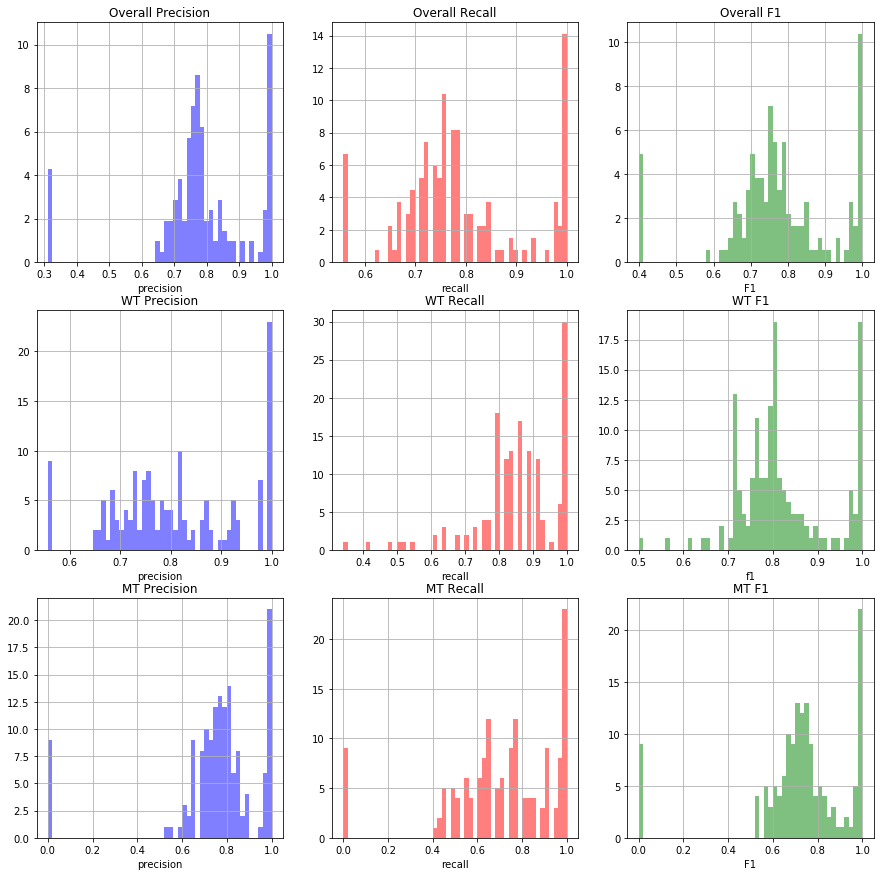

votes for type 0 (no threshold):  (17, 18)
votes for type 1 (no threshold):  (135, 18)
votes for type 0 (m_f1>0.5):  (8, 18)
votes for type 1 (m_f1>0.5):  (135, 18)


In [71]:
process_row_data('./output/r1_med_AT.csv', './analysis/r1_med_AT_result.csv')
analyse_result('./analysis/r1_med_AT_result.csv')

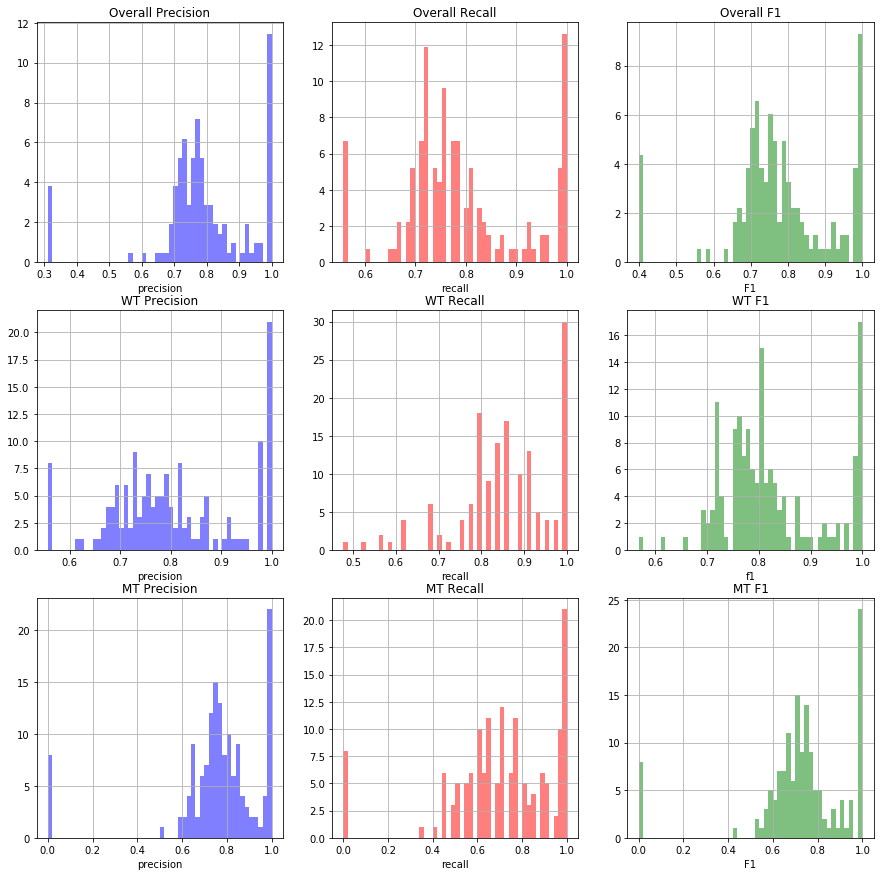

votes for type 0 (no threshold):  (16, 18)
votes for type 1 (no threshold):  (136, 18)
votes for type 0 (m_f1>0.5):  (8, 18)
votes for type 1 (m_f1>0.5):  (135, 18)


In [72]:
process_row_data('./output/r1_2med_AT.csv', './analysis/r1_2med_AT_result.csv')
analyse_result('./analysis/r1_2med_AT_result.csv')

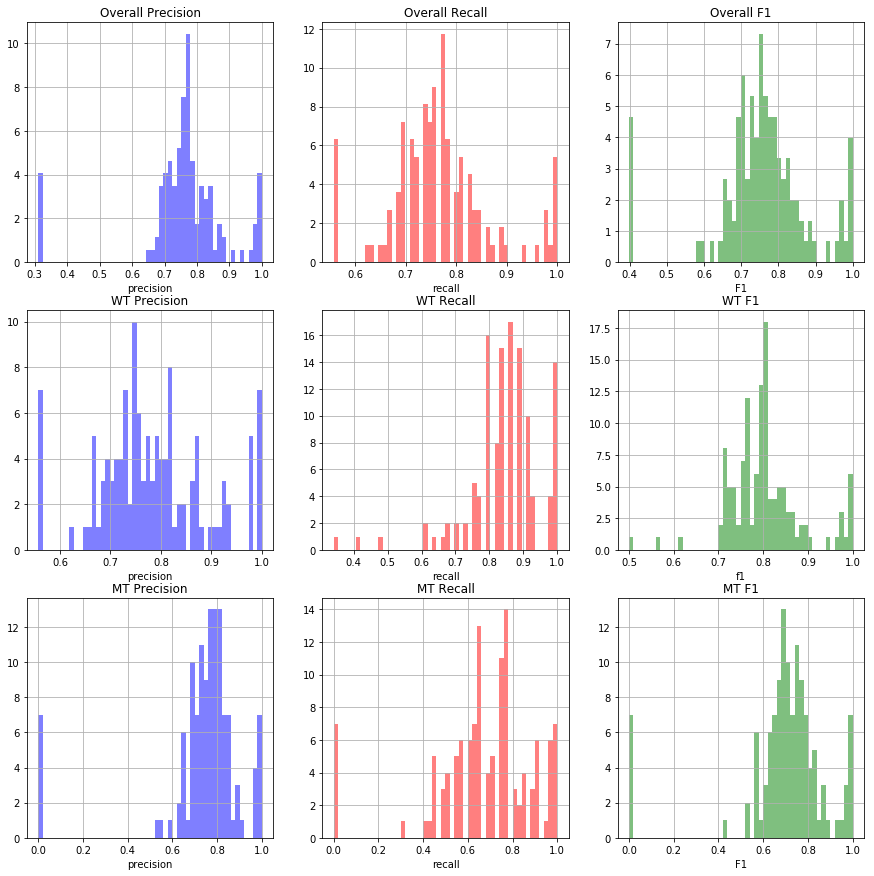

votes for type 0 (no threshold):  (17, 18)
votes for type 1 (no threshold):  (108, 18)
votes for type 0 (m_f1>0.5):  (9, 18)
votes for type 1 (m_f1>0.5):  (108, 18)


In [75]:
process_row_data('./output/r2_med_AT.csv', './analysis/r2_med_AT_result.csv')
analyse_result('./analysis/r2_med_AT_result.csv')

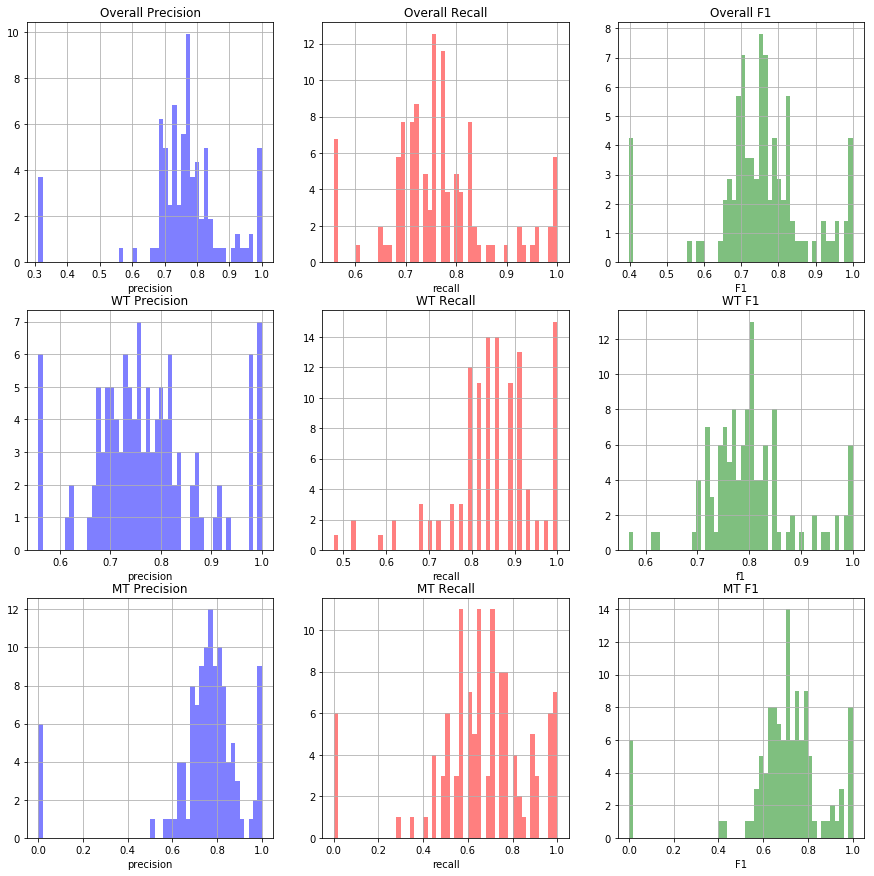

votes for type 0 (no threshold):  (21, 18)
votes for type 1 (no threshold):  (96, 18)
votes for type 0 (m_f1>0.5):  (14, 18)
votes for type 1 (m_f1>0.5):  (95, 18)


In [76]:
process_row_data('./output/r2_2med_AT.csv', './analysis/r2_2med_AT_result.csv')
analyse_result('./analysis/r2_2med_AT_result.csv')